In [63]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from cryo_sbi import CryoEmSimulator
import cryo_sbi.inference.train_npe_model as train_npe_model
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils

import umap

### Make models

In [64]:
distance_centers = torch.linspace(0, 20, 100)

In [65]:
models = torch.tensor([[[0., 0.],[-dist, dist],[0., 0.]] for dist in distance_centers])
torch.save(models, 'models.pt')

### Run first simulation

```
simulation_parameters.json

{
    "N_PIXELS": 64,             --> size of the image
    "PIXEL_SIZE": 2.0,          --> pixel size in angstroms
    "SIGMA": [2.0, 2.0],        --> standard deviation of the gaussian
    "MODEL_FILE": "models.pt",  --> file which contains the models
    "SHIFT": 0.0,               --> shift of model center 
    "DEFOCUS": [2.0, 2.0],      --> defocus values
    "SNR": [0.01, 0.5],         --> signal to noise ratio 
    "AMP": 0.1,                 --> amplitude of the model 
    "B_FACTOR": [1.0, 1.0]      --> b factor
} 
```

In [66]:
simulator = CryoEmSimulator("simulation_parameters.json")

In [67]:
images, parameters = simulator.simulate(num_sim=5000, return_parameters=True)

/home/dingeldein/Desktop/cryo_em_SBI/src/cryo_sbi/wpa_simulator/cryo_em_simulator.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = torch.tensor(indices, dtype=torch.float32)


In [68]:
dist = parameters[0]
snr = parameters[-1]

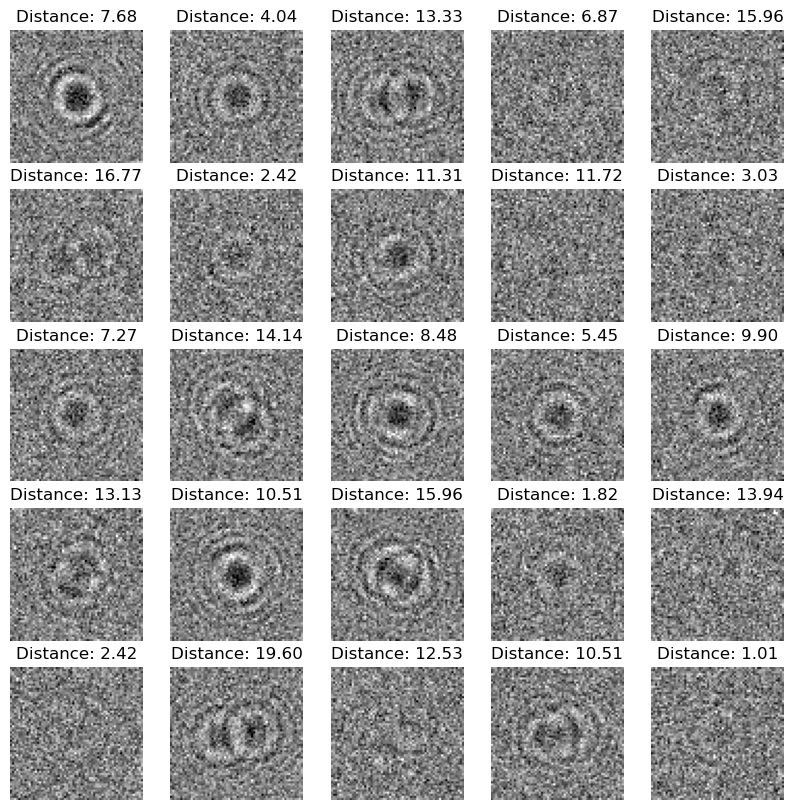

In [69]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(images[idx], vmin=-3, vmax=3, cmap="gray")
    ax.set_title(f"Distance: {distance_centers[dist[idx].round().long()].item():.2f}")
    ax.axis('off')

### Train cryoSBI posterior

```
train_config.json
```

```
{
    "EMBEDDING": "ConvEncoder64x64",        --> embedding network for the images
    "OUT_DIM": 128,                         --> dimension of the embedding
    "NUM_TRANSFORM": 5,                     --> number of transformations
    "NUM_HIDDEN_FLOW": 5,                   --> number of hidden layers in the flow
    "HIDDEN_DIM_FLOW": 128,                 --> dimension of the hidden layers in the flow
    "MODEL": "NSF",                         --> type of flow
    "LEARNING_RATE": 0.0003,                --> learning rate
    "CLIP_GRADIENT": 5.0,                   --> gradient clipping
    "THETA_SHIFT": 50,                      --> shift of the model center
    "THETA_SCALE": 50,                      --> scale of the model
    "BATCH_SIZE": 32                        --> batch size
}
```


In [70]:
train_npe_model.npe_train_no_saving(
    "simulation_parameters.json",
    "train_config.json",
    100,
    "tutorial_estimator.pt",
    "tutorial.loss",
    n_workers=4,
    device="cuda",
    saving_frequency=100,
    simulation_batch_size=160,
)

Training neural netowrk:


  0%|          | 0/100 [00:00<?, ?epoch/s]

100%|██████████| 100/100 [11:55<00:00,  7.15s/epoch, loss=-.406]


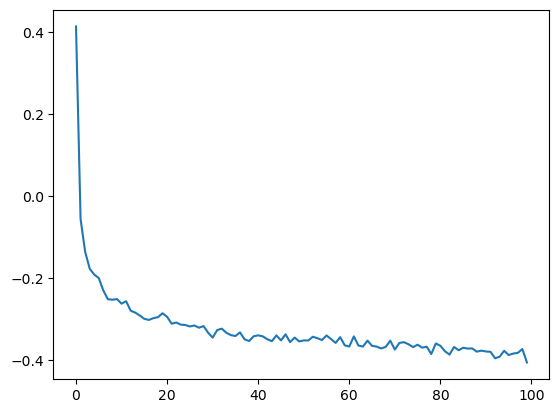

In [71]:
plt.plot(torch.load("tutorial.loss"))

### Evaluate posterior

In [72]:
posterior = est_utils.load_estimator(
    "train_config.json",
    "tutorial_estimator.pt",
    device="cuda",
)


In [73]:
samples = est_utils.sample_posterior(
    estimator=posterior,
    images=images,
    num_samples=15000,
    batch_size=1000,
    device="cuda",
)

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


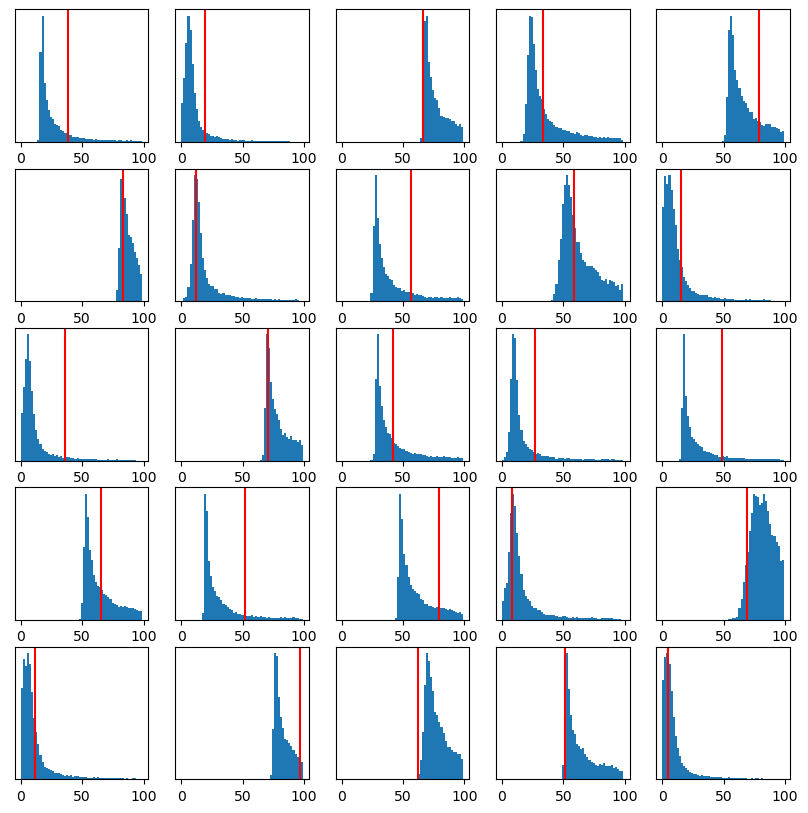

In [74]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(0, simulator.max_index, 60))
    ax.axvline(dist[idx], ymax=1, ymin=0, color="red")
    ax.set_yticks([])

### Plot latent space

In [75]:
latent_representations = est_utils.compute_latent_repr(
    estimator=posterior,
    images=images,
    batch_size=1000,
    device="cuda",
)

In [76]:
reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=50)
latent_vecs_transformed = reducer.fit_transform(latent_representations.numpy())

[]

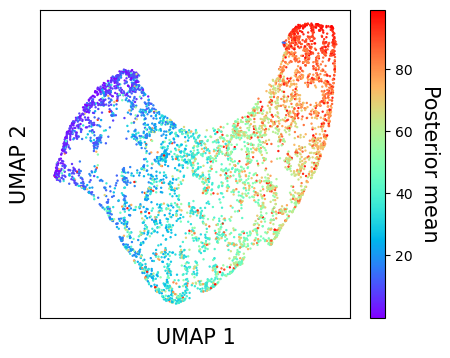

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

scatter = axes.scatter(
    latent_vecs_transformed[:, 0],
    latent_vecs_transformed[:, 1],
    c=dist,
    s=0.5,
    cmap="rainbow",
    #vmin=0,
    #vmax=70,
)

cbar = plt.colorbar(mappable=scatter)
cbar.set_label('Posterior mean', rotation=270, fontsize=15, labelpad=20)


axes.set_xlabel("UMAP 1", fontsize=15)
axes.set_ylabel("UMAP 2", fontsize=15)

axes.set_xticks([])
axes.set_yticks([])